# Lidwoorden
## Details
> Lidwoorden    worden    tegenwoordig    nog    steeds weggelaten uit krantenkoppen. In de analyse wordt er enkel   gekeken   naar   lidwoorden   die   kunnen weggelaten  worden;we  nemen  dus  vaste  clusters (bv.uit  de  biecht  klappen,  uit  de  hand  lopen,  het wordt,  enz.)  en  lidwoorden  in  quotes  niet  op  in  de analyse.

Just detecting articles is easy. The harder part is that not all articles are left uit (2nd part of description).
## Example
> Arrestant klimt op dak van rijdende politiewagen,  maar  agent  heeft deoplossing: gewoon doorrijden


## Data

In [1]:
from util import get_cls_train_test

train_x, train_y, test_x, test_y = get_cls_train_test("Lidwoorden")
train_y.value_counts()

0    556
1    125
Name: Lidwoorden, dtype: int64

## Approach 1: Hardcoded articles function

In [3]:
import re


def contains_article(headline):
    headline_lower = headline.lower()
    headline_letters_only = re.sub("[^a-z ]+", "", headline_lower)
    headline_splitted = headline_letters_only.split()
    return any(article in headline_splitted for article in ['de', 'het', 'een'])

f-score: 0.5899280575539569
Confusion matrix: (TP: 130, FP: 57, FN: 0, TN: 41)
Accuracy=75.00% (171/228)


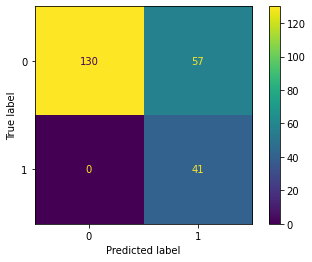

In [5]:
from util import print_evaluation

prediction = test_x.apply(contains_article)
print_evaluation(test_y, prediction)

### Approach 2: Less Simple Function
Note: This is also a manual implemented function, so I must be careful with overfitting. I still want to try this, because there is a clear definition.

In [6]:
import re


def remove_text_between_quotes(headline):
    return re.sub(r'"(.*?)"', '', headline)


def contains_article_advanced(headline):
    # Detect wether "de" is in the headline, unless when it's between quotes
    # Since the definition explicitly stated articles might still occur between quotes, let's try to check for that
    return contains_article(remove_text_between_quotes(headline))


contains_article_advanced(
    'Woordvoerder eenden spreekt: "De toestand is verschrikkelijk"')  # Should be false (made up headline)

False

f-score: 0.6612903225806451
Confusion matrix: (TP: 145, FP: 42, FN: 0, TN: 41)
Accuracy=81.58% (186/228)


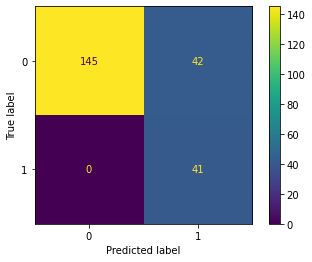

In [7]:
prediction = test_x.apply(contains_article_advanced)
print_evaluation(test_y, prediction)

Slightly better than the previous, but still not ideal. My guess is that this is because we still have quite some articles in some fixed expressions, like mentioned in the description. Let's take a look at the misclassifications in the training set:


In [10]:
# False positives
prediction = train_x.apply(contains_article_advanced)
train_x[(prediction != train_y) & (prediction == 1)][:5]

Test      
705   1764    Een doodnormale job: hiervoor kiezen seriemoor...
500   1249    Dit is het enige hotel in Vlaanderen met meer ...
3     4       Maandag drukste dag van het jaar op Brussels A...
896   2228    Nieuwe kans voor Bart De Pauw in project van F...
502   1256    Dit hotel is het enige in Vlaanderen met meer ...
Name: Headline, dtype: object

There are different reasons for wrong predictions in those examples e.g. fixed expressions (e.g. "een beetje, "het enige"), names (e.g. "Bart De Pauw"), ans probably also some misclassifications in the dataset (e.g. "Een doodnormale job", "een ISIS-leider").

## Approach 3: Tf-idf
Since it should just recognize articles, tf-idf should be able to do the job (but this probably won’t produce that good results, since it still takes text in quotes in account, but we can try to fix that later). I guess the problems from previous approach will still persist using this.

f-score: 0.4507042253521127
Confusion matrix: (TP: 173, FP: 14, FN: 25, TN: 16)
Accuracy=82.89% (189/228)


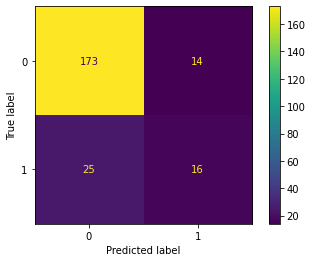

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from imblearn.pipeline import Pipeline

from util import fit_predict_evaluate

model = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', svm.LinearSVC(random_state=42))
])

fit_predict_evaluate(model, train_x, train_y, test_x, test_y)

This has a lower f-score and a slightly higher accuracy.

In [17]:
from util import show_most_informative_features

show_most_informative_features(model, n=20)

3.7084             de    -0.6987         sennek
2.5818            een    -0.6565            dit
1.9926            het    -0.6369            was
0.8775          staat    -0.6220            één
0.8288             zo    -0.5969           hand
0.8234           lang    -0.5315         punten
0.7877           ligt    -0.5264      verdienen
0.7147         eerste    -0.5159           bart
0.6978      resultaat    -0.5078            aan
0.6844         kijken    -0.5045          maand
0.6607            kim    -0.4974           meer
0.6457          reden    -0.4961       jongeren
0.6389         kicken    -0.4958      herbeleef
0.6308          radja    -0.4918          meest
0.6111        vlaamse    -0.4901         biecht
0.6069         winnen    -0.4679          deden
0.6063           jaar    -0.4678         palace
0.5872         zoveel    -0.4678     buckingham
0.5841            per    -0.4678           blik
0.5787      doorbraak    -0.4664       momenten


As expected, "de", "het" and "een" have the highest impact on the results. "Biecht" is probably important because it helps recognizing expressions like "uit de biecht".

## Approach 4: Tf-idf with multiple words
Since articles in expressions aren't seen as positive, we have to take those expression into account. However, tf-idf only looks at the words one by one. Let's try to apply the same principle, but instead of bags of one word, use bags of two or three words.

[Sklearns TfIdfVectorizer documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) has some useful information. The analyzer determines how to split the text. The default is splitting on whitespaces ("words"), but based on character n-grams is also possible. Let's search whether word n-grams is also an option.

In [18]:
# Code based on documentation: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
# and on Stackoverflow: https://stackoverflow.com/questions/21600196/how-do-i-use-sklearn-countvectorizer-with-both-word-and-char-analyzer-pyt
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=1)
x = ['never gonna give you up', 'never gonna let you down']
tfidf_vectorizer.fit_transform(x)
tfidf_vectorizer.get_feature_names_out()

array(['down', 'give', 'give you', 'gonna', 'gonna give', 'gonna let',
       'let', 'let you', 'never', 'never gonna', 'up', 'you', 'you down',
       'you up'], dtype=object)

### 1-2 words

f-score: 0.49382716049382713
Confusion matrix: (TP: 167, FP: 20, FN: 21, TN: 20)
Accuracy=82.02% (187/228)


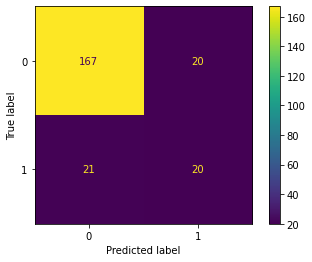

In [22]:
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek

model = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
    ('resampler', SMOTETomek(random_state=42)),
    ('classifier', svm.LinearSVC(random_state=0))
])

fit_predict_evaluate(model, train_x, train_y, test_x, test_y)

In [23]:
show_most_informative_features(model, n=20)

4.2575             de    -0.5148        voor de
2.8539            een    -0.4753            één
2.1315            het    -0.4377            was
1.4734          op de    -0.4343         sennek
1.1043         van de    -0.4255         wat is
0.9705             zo    -0.4165             na
0.9416          en de    -0.3847           niet
0.9117         in het    -0.3846            aan
0.7896         en een    -0.3838    prins harry
0.7362         en het    -0.3801           werd
0.6977         eerste    -0.3665           voor
0.6732        van het    -0.3655           geen
0.6284          staat    -0.3541           mijn
0.5928          reden    -0.3517       dit zijn
0.5870           ligt    -0.3514         er aan
0.5688          is de    -0.3465            dit
0.5615      resultaat    -0.3442           meer
0.5495           jaar    -0.3406          is er
0.5479       staat er    -0.3392             af
0.5353      lang niet    -0.3307       jongeren


There aren't really expressions in this list. Based on this word list, I would gues "op de"and "van de" are more used in expressions than "voor de". However it's strange we have a decrease in accuracy and f-score.

### 1-3 words

f-score: 0.4578313253012048
Confusion matrix: (TP: 164, FP: 23, FN: 22, TN: 19)
Accuracy=80.26% (183/228)


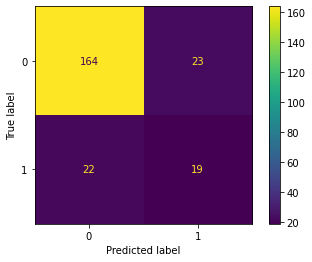

In [25]:
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek

model = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 3))),
    ('resampler', SMOTETomek(random_state=42)),
    ('classifier', svm.LinearSVC(random_state=0))
])

fit_predict_evaluate(model, train_x, train_y, test_x, test_y)

In [26]:
show_most_informative_features(model)

4.1982             de    -0.4055             na
2.7452            een    -0.3853            één
1.9821            het    -0.3807        voor de
1.3763          op de    -0.3627           voor
1.1134         van de    -0.3529           geen
0.8973             zo    -0.3515            aan
0.8112          en de    -0.3493           niet
0.7879         in het    -0.3241            was
0.6903         eerste    -0.3127           meer
0.6876         en een    -0.3125        politie


Strangely again a lower accuracy and f-score. We can't increase the minimum number of words, because "de", "een" and "het" are still the most important to be recognized.

### Approach 5: Remove Quotations + Bag of (bi-)Words
The definition stated that articles in expressions or quotes aren't taken into account. The bi-grams help to check for expressions (hopefully), let's also use the function to remove the quotes before feeding the data to the vectorizer.

f-score: 0.6233766233766234
Confusion matrix: (TP: 175, FP: 12, FN: 17, TN: 24)
Accuracy=87.28% (199/228)


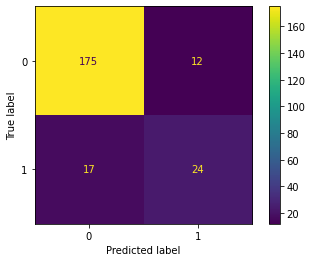

In [36]:
from sklearn.base import BaseEstimator, TransformerMixin
from util import FunctionTransformer
import numpy as np

class QuotationRemover(BaseEstimator, TransformerMixin):
    # For some reason this didn't work with the FunctionTransformer
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return np.vectorize(lambda headline: re.sub(r'"(.*?)"', '', headline))(X)

model = Pipeline([
    ('quotation-remover', QuotationRemover()),
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
    ('classifier', svm.LinearSVC(random_state=0))
])

fit_predict_evaluate(model, train_x, train_y, test_x, test_y)

## Approach 3: Extra features

In [48]:
from sklearn.pipeline import FeatureUnion

class AricleChecker(BaseEstimator, TransformerMixin):
    # For some reason this didn't work with the FunctionTransformer
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # return X.apply(contains_article)
        return np.vectorize(contains_article)(X)

model = Pipeline([
    ('quotation-remover', QuotationRemover()),
    ('union', FeatureUnion([
        ('vectorizer', TfidfVectorizer(ngram_range=(2, 3))),
        ('contains_article', AricleChecker()),
    ])),
    ('classifier', svm.LinearSVC(random_state=0))
])

fit_predict_evaluate(model, train_x, train_y, test_x, test_y)

ValueError: blocks[0,:] has incompatible row dimensions. Got blocks[0,1].shape[0] == 1, expected 681.

This errors for some reason.